# Decomposition of Synthetic Tucker tensor using gradient descent

In [2]:
import numpy as np
from scipy import sparse
import matplotlib.pylab as plt
import tensor
%matplotlib inline 

In [10]:
# Generate synthetic Tucker tensor
sz=(50, 50, 20)
dtrue=(7, 8, 9)
X0=tensor.randtensor3(sz,dtrue)

(0, 10)

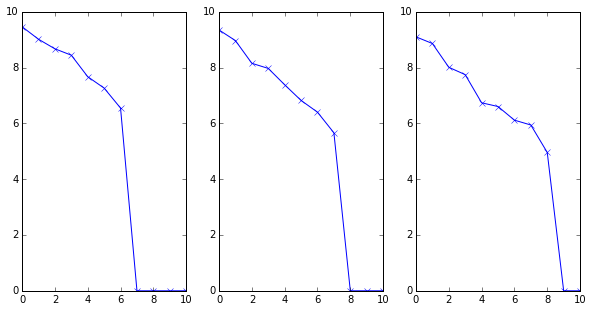

In [15]:
# Plot the singular values
plt.rcParams['figure.figsize']=(10,5)
plt.subplot(1,3,1); plt.plot(np.linalg.svd(tensor.unfold(X0,0),compute_uv=False),'-x'); plt.xlim(0,10)
plt.subplot(1,3,2); plt.plot(np.linalg.svd(tensor.unfold(X0,1),compute_uv=False),'-x'); plt.xlim(0,10)
plt.subplot(1,3,3); plt.plot(np.linalg.svd(tensor.unfold(X0,2),compute_uv=False),'-x'); plt.xlim(0,10)

In [241]:
# Take random samples
M=6000
ind=np.random.permutation(np.prod(sz));
ind_tr=ind[:M]
ind_te=ind[M:]
Ytr=[X0.ravel()[i] for i in ind_tr]
Yte=[X0.ravel()[i] for i in ind_te]

In [242]:
# Vectorize the data and get the indices
scale=np.array(Ytr).std()
yvec=Ytr/scale
I,J,K=np.unravel_index(ind_tr,sz)
Ite,Jte,Kte=np.unravel_index(ind_te,sz)

In [243]:
# Prepare index matrices
indU = sparse.coo_matrix((np.ones(M),(I,range(M))),shape=(sz[0],M))
indV = sparse.coo_matrix((np.ones(M),(J,range(M))),shape=(sz[1],M))
indW = sparse.coo_matrix((np.ones(M),(K,range(M))),shape=(sz[2],M))

In [244]:
# Initialize randomly
dd=dtrue
U=np.random.randn(sz[0],dd[0])/np.sqrt(sz[0])
V=np.random.randn(sz[1],dd[1])/np.sqrt(sz[1])
W=np.random.randn(sz[2],dd[2])/np.sqrt(sz[2])
C=np.random.randn(dd[0],dd[1],dd[2])

In [245]:
# Gradient descent
maxiter=1000
lmd=0
step=2e-3
for kk in range(maxiter):
    pred = ((np.dot(C, W[K,:].T) * V[J,:].T).sum(1) * U[I,:].T).sum(0)
    gg = (pred- yvec).reshape((M,1))
    Unew = (1-step*lmd) * U - step * (indU*(gg * (np.dot(C, W[K,:].T) * V[J,:].T).sum(1).T))
    Vnew = (1-step*lmd) * V - step * (indV*(gg * (np.dot(C, W[K,:].T).transpose((1,0,2)) * U[I,:].T).sum(1).T))
    Wnew = (1-step*lmd) * W - step * (indW*(gg * (np.dot(C.transpose(2,0,1), V[J,:].T) * U[I,:].T).sum(1).T))
    Cnew = (1-step*lmd) * C - step * (U[I,:].T.reshape((dd[0],1,M,1)) * (V[J,:].T.reshape((dd[1],M,1)) * (gg * W[K,:]))).sum(2)
    U, V, W, C=Unew, Vnew, Wnew, Cnew
    if kk % 100 == 0:
        print 'kk=%d error=%g' % (kk, (gg**2).sum()/M)

kk=0 error=1.0076
kk=100 error=0.305321
kk=200 error=0.152619
kk=300 error=0.0859686
kk=400 error=0.041905
kk=500 error=0.0218124
kk=600 error=0.0112118
kk=700 error=0.00604596
kk=800 error=0.00343939
kk=900 error=0.00203602


In [248]:
# Predict the missing entries
pred = ((np.dot(C, W[Kte,:].T) * V[Jte,:].T).sum(1) * U[Ite,:].T).sum(0)
np.mean((pred-Yte/scale)**2)

0.0028016817740168006

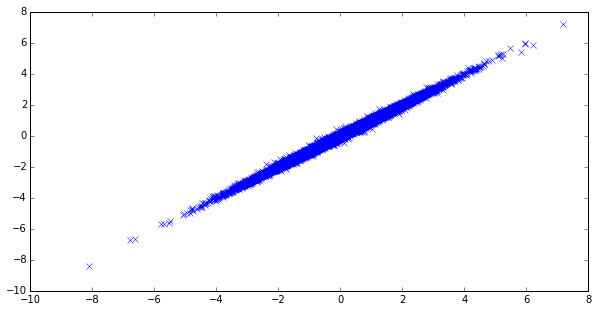

In [247]:
plt.plot(pred , Yte/scale, 'x')